In [12]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [13]:
root_dir = Path('data', 'ros2_lidar_experiments', 'ros2_lidar_experiments')
distances_dir = root_dir / 'distances'

In [14]:
headers = [
    'sec',
    'nanosec',
    'frame_id',
    'angle_min',
    'angle_max',
    'angle_increment',
    'time_increment',
    'scan_time',
    'range_min',
    'range_max',
    'ranges',
    'intensities'
]

headers_constructed = headers[:-2]
for i in range(128):
    headers_constructed.append(f'range_{i}')

for i in range(128):
    headers_constructed.append(f'intensity_{i}')

In [15]:
def load_df(file: Path) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = df.drop(columns=['...', '....1']) # truncated entries - no use
    df.columns = headers_constructed
    df['filename'] = file.name
    df['distance'] = extract_distance_from_filename(file.name)
    return df

def extract_distance_from_filename(filename: str) -> float:
    mo = re.search(r'\d+\-\d+', filename)
    if mo is None:
        raise ValueError(f'Invalid filename: {filename}')
    
    distance_str = mo.group(0).replace('-', '.')
    return float(distance_str)

distance_dfs = []
for file in distances_dir.glob(r'd*-*.csv'):
    df = load_df(file)
    distance_dfs.append(df)

df = pd.concat(distance_dfs)

In [18]:
df

,sec,nanosec,frame_id,angle_min,angle_max,angle_increment,time_increment,scan_time,range_min,range_max,...,intensity_120,intensity_121,intensity_122,intensity_123,intensity_124,intensity_125,intensity_126,intensity_127,filename,distance
0,1763031069,897476143,laser,-3.124139,3.141593,0.003483,0.000054,0.096712,0.15,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,47.0,47.0,d_d_5-0.csv,5.0
1,1763031069,995956608,laser,-3.124139,3.141593,0.003483,0.000057,0.102634,0.15,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,47.0,47.0,d_d_5-0.csv,5.0
2,1763031070,100324519,laser,-3.124139,3.141593,0.003483,0.000054,0.096571,0.15,16.0,...,0.0,0.0,0.0,0.0,0.0,47.0,47.0,47.0,d_d_5-0.csv,5.0
3,1763031070,198681870,laser,-3.124139,3.141593,0.003483,0.000054,0.096294,0.15,16.0,...,0.0,0.0,0.0,0.0,47.0,47.0,47.0,47.0,d_d_5-0.csv,5.0
4,1763031070,296467733,laser,-3.124139,3.141593,0.003483,0.000057,0.102975,0.15,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d_d_5-0.csv,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1763030391,681421661,laser,-3.124139,3.141593,0.003483,0.000057,0.102362,0.15,16.0,...,0.0,0.0,0.0,0.0,47.0,47.0,47.0,47.0,d_0-7.csv,0.7
117,1763030391,785433744,laser,-3.124139,3.141593,0.003483,0.000057,0.102730,0.15,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d_0-7.csv,0.7
118,1763030391,889864218,laser,-3.124139,3.141593,0.003483,0.000054,0.096591,0.15,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,47.0,47.0,d_0-7.csv,0.7
119,1763030391,988148216,laser,-3.124139,3.141593,0.003483,0.000057,0.102682,0.15,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d_0-7.csv,0.7


In [5]:
df.to_csv('data/distances_cleaned.csv', index=False)

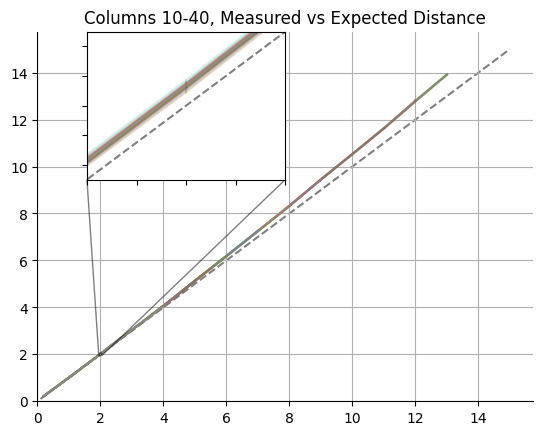

In [6]:
from IPython.display import display

range_str = 'range_15'
for i in range(10, 40):
    range_str = f'range_{i}'
    distances = df.groupby('distance').agg(func={range_str: ['mean', 'std']})
    distances.columns = ['mean', 'std']

    x = distances.index
    y = distances['mean'].values
    yerr = distances['std'].values

    plt.errorbar(x, y, yerr=yerr, label=f'Measured (col{i})', fmt='-', alpha=0.2)

plt.plot(x, x, label='Expected', c='black', alpha=0.5, linestyle='--', zorder=-1)
plt.grid()
plt.xlim(0, None)
plt.ylim(0, None)
plt.title('Columns 10-40, Measured vs Expected Distance')


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.show()

x1, x2, y1, y2 = 1.95, 2.05, 1.95, 2.05
bounds = [0.1, 0.6, 0.4, 0.4]
axins = ax.inset_axes(bounds, xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
ax.indicate_inset_zoom(axins, edgecolor="black")

for i in range(10, 40):
    range_str = f'range_{i}'
    distances = df.groupby('distance').agg(func={range_str: ['mean', 'std']})
    distances.columns = ['mean', 'std']

    x = distances.index
    y = distances['mean'].values
    yerr = distances['std'].values

    axins.errorbar(x, y, yerr=yerr, label=f'Measured (col{i})', fmt='-', alpha=0.2)

axins.plot(x, x, label='Expected', c='black', alpha=0.5, linestyle='--', zorder=-1)

# display(plt.gcf())

# plt.title('Zoomed in view of columns 10-30')
# plt.xlim(1.95, 2.05)
# plt.ylim(1.95, 2.05)
# display(plt.gcf())

# plt.show()

Text(47.097222222222214, 0.5, 'LIDAR-measured distance (m)')

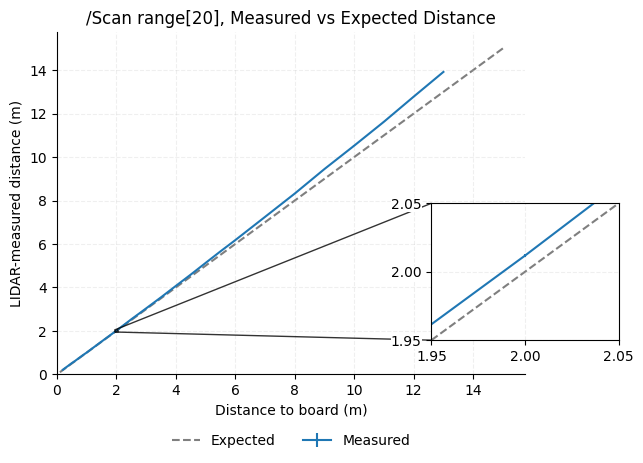

In [22]:
range_str = 'range_15'
distances = df.groupby('distance').agg(func={range_str: ['mean', 'std']})
distances.columns = ['mean', 'std']

x = distances.index
y = distances['mean'].values
yerr = distances['std'].values

plt.errorbar(x, y, yerr=yerr, label=f'Measured', fmt='-', alpha=1.0)

plt.plot(x, x, label='Expected', c='black', alpha=0.5, linestyle='--', zorder=-1)
plt.grid(alpha=0.2, linestyle='--')
plt.legend(frameon=False, loc='lower center', ncols=2, bbox_to_anchor=(0.5, -0.25))
plt.xlim(0, None)
plt.ylim(0, None)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('/Scan range[20], Measured vs Expected Distance')

x1, x2, y1, y2 = 1.95, 2.05, 1.95, 2.05
bounds = [0.8, 0.1, 0.4, 0.4]
axins = ax.inset_axes(bounds, xlim=(x1, x2), ylim=(y1, y2), xticks=[1.95, 2.0, 2.05], yticks=[1.95, 2.0, 2.05])
axins.grid(alpha=0.2, linestyle='--')
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.8)

axins.errorbar(x, y, yerr=yerr, fmt='-', alpha=1.0)
axins.plot(x, x, label='Expected', c='black', alpha=0.5, linestyle='--', zorder=-1)

# add white background to the inset ticks
for label in axins.get_xticklabels() + axins.get_yticklabels():
    label.set_bbox(dict(
        facecolor="white",
        edgecolor="none",   # or a color if you want an outline
        pad=0.2
    ))

plt.tight_layout()
plt.xlabel('Distance to board (m)')
plt.ylabel('LIDAR-measured distance (m)')

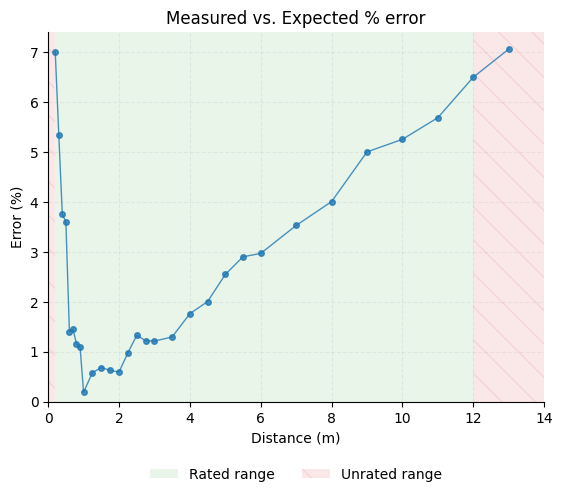

In [24]:
range_str = 'range_15'
distances = df.groupby('distance').agg(func={range_str: ['mean', 'std']})
distances.columns = ['mean', 'std']

vals = distances.reset_index()
vals['err'] = (vals['mean'] / vals['distance']) - 1
vals['err'] *= 100
vals
plt.plot(vals['distance'], vals['err'], marker='o', markersize=4, linewidth=1, alpha=0.8)

plt.grid(alpha=0.2, linestyle='--')
plt.title('Measured vs. Expected % error')
plt.ylabel('Error (%)')
plt.xlabel('Distance (m)')
plt.xlim(0, 14)
plt.ylim(0, None)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvspan(0.2, 12, alpha=0.1, color='tab:green', lw=0, label='Rated range')
ax.axvspan(0.0, 0.2, alpha=0.1, color='tab:red', lw=0, label='Unrated range', hatch='\\')
ax.axvspan(12, 14, alpha=0.1, color='tab:red', lw=0, hatch='\\')
plt.legend(frameon=False, loc='lower center', ncols=2, bbox_to_anchor=(0.5, -0.25))